In [1]:
# 03.0 — setup
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path.cwd()
if str(PROJECT_ROOT) not in sys.path: sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
# 03.1 — load raw data
df = pd.read_csv(PROJECT_ROOT / "data" / "raw" / "simulated_sensor_data.csv", parse_dates=['timestamp'])
SENSOR_COLS = ['temperature','vibration','pressure','rpm']
df.head()


,timestamp,machine_id,temperature,vibration,pressure,rpm,failure
0,2025-11-09 12:24:47.878597,1,60.458,0.3524,1.057,1435,0
1,2025-11-09 12:25:47.878597,1,60.477,0.3471,1.053,1430,0
2,2025-11-09 12:26:47.878597,1,60.470,0.3448,1.043,1431,0
3,2025-11-09 12:27:47.878597,1,60.451,0.3315,1.054,1434,0
4,2025-11-09 12:28:47.878597,1,60.494,0.3447,1.041,1433,0


In [3]:
# 03.2 — Dataset builder (sliding window)
class SeqDataset(Dataset):
    def __init__(self, df, window=50, horizon=10):
        self.samples = []
        for mid, g in df.groupby('machine_id'):
            g = g.sort_values('timestamp').reset_index(drop=True)
            for end in range(window, len(g) - horizon):
                seq = g[SENSOR_COLS].iloc[end-window:end].values.astype(np.float32)
                label = 1 if g['failure'].iloc[end:end+horizon].sum() > 0 else 0
                self.samples.append((seq, label))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]


In [4]:
# 03.3 — LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return torch.sigmoid(self.fc(out)).squeeze(-1)


In [5]:
# 03.4 — Prepare data & train
train_ids = df['machine_id'].unique()[:int(0.8*df['machine_id'].nunique())]
train_df = df[df['machine_id'].isin(train_ids)]
test_df = df[~df['machine_id'].isin(train_ids)]

train_ds = SeqDataset(train_df)
test_ds = SeqDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()


In [6]:
# 03.5 — Training loop
for epoch in range(3):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.float().to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1 | Loss: 0.4765
Epoch 2 | Loss: 0.3787
Epoch 3 | Loss: 0.3723


In [7]:
# 03.6 — Save model
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "lstm_model.pt")
print("✅ LSTM model saved to models/lstm_model.pt")


✅ LSTM model saved to models/lstm_model.pt


In [1]:
# 01_setup
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt
print("Project root:", PROJECT_ROOT)
print("PyTorch device:", "cuda" if torch.cuda.is_available() else "cpu")


Project root: C:\Users\LENOVO\Desktop\Projects\predictive_maintenance
PyTorch device: cpu


In [2]:
# 02_defs
SENSOR_COLS = ['temperature','vibration','pressure','rpm']  # adjust if you added new sensors

class SeqDataset(Dataset):
    def __init__(self, df, window=50, horizon=10):
        self.samples = []
        for mid, g in df.groupby('machine_id'):
            g = g.sort_values('timestamp').reset_index(drop=True)
            for end in range(window, len(g) - horizon):
                seq = g[SENSOR_COLS].iloc[end-window:end].values.astype('float32')
                label = 1 if g['failure'].iloc[end:end+horizon].sum() > 0 else 0
                self.samples.append((seq, label))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        logits = self.fc(out)      # return logits for BCEWithLogitsLoss
        return logits.squeeze(-1)


In [3]:
# 03_data
raw_csv = PROJECT_ROOT / "data" / "raw" / "simulated_sensor_data.csv"
df = pd.read_csv(raw_csv, parse_dates=['timestamp'])
print("Loaded rows:", len(df), "machines:", df['machine_id'].nunique())

# Split machines by id for train/test (ensures no leakage)
machine_ids = sorted(df['machine_id'].unique())
split = int(0.8 * len(machine_ids))
train_ids = set(machine_ids[:split])
train_df = df[df['machine_id'].isin(train_ids)].reset_index(drop=True)
test_df = df[~df['machine_id'].isin(train_ids)].reset_index(drop=True)
print("Train machines:", len(train_df['machine_id'].unique()), "Test machines:", len(test_df['machine_id'].unique()))

WINDOW = 50
HORIZON = 10
BATCH_SIZE = 64

train_ds = SeqDataset(train_df, window=WINDOW, horizon=HORIZON)
test_ds = SeqDataset(test_df, window=WINDOW, horizon=HORIZON)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

print("Train samples:", len(train_ds), "Test samples:", len(test_ds))


Loaded rows: 9600 machines: 8
Train machines: 6 Test machines: 2
Train samples: 6840 Test samples: 2280


In [4]:
# 04_train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim=len(SENSOR_COLS), hidden_dim=64, num_layers=1).to(device)

# Use weighted loss if classes are imbalanced (optional)
# compute pos_weight
all_labels = np.array([lbl for _, lbl in train_ds.samples])
pos = (all_labels == 1).sum()
neg = (all_labels == 0).sum()
pos_weight = torch.tensor((neg / (pos + 1e-9)), dtype=torch.float32).to(device)
print(f"pos={pos} neg={neg} pos_weight={pos_weight.item():.3f}")

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)   # logits expected
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 8

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    seen = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.float().to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        running_loss += loss.item() * xb.size(0)
        running_correct += (preds.cpu().numpy() == yb.cpu().numpy()).sum()
        seen += xb.size(0)

    train_loss = running_loss / seen
    train_acc = running_correct / seen

    # validation
    model.eval()
    v_loss = 0.0; v_correct = 0; v_seen = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device); yb = yb.float().to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            v_loss += loss.item() * xb.size(0)
            v_correct += (preds.cpu().numpy() == yb.cpu().numpy()).sum()
            v_seen += xb.size(0)

    val_loss = v_loss / v_seen if v_seen>0 else 0.0
    val_acc = v_correct / v_seen if v_seen>0 else 0.0

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

# save model and history
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "lstm_model.pt")
import joblib
joblib.dump(history, PROJECT_ROOT / "models" / "lstm_history.joblib")
print("Saved model and training history.")


pos=847 neg=5993 pos_weight=7.076
Epoch 1/8 - train_loss: 1.2151, train_acc: 0.3165 - val_loss: 1.1379, val_acc: 0.8934
Epoch 2/8 - train_loss: 1.2154, train_acc: 0.4854 - val_loss: 1.1403, val_acc: 0.8934
Epoch 3/8 - train_loss: 1.2162, train_acc: 0.6392 - val_loss: 1.1451, val_acc: 0.1066
Epoch 4/8 - train_loss: 1.2156, train_acc: 0.5057 - val_loss: 1.1406, val_acc: 0.8934
Epoch 5/8 - train_loss: 1.2160, train_acc: 0.5621 - val_loss: 1.1428, val_acc: 0.1066
Epoch 6/8 - train_loss: 1.2156, train_acc: 0.4360 - val_loss: 1.1443, val_acc: 0.1066
Epoch 7/8 - train_loss: 1.2157, train_acc: 0.4981 - val_loss: 1.1445, val_acc: 0.1066
Epoch 8/8 - train_loss: 1.2146, train_acc: 0.6212 - val_loss: 1.1508, val_acc: 0.1066
Saved model and training history.


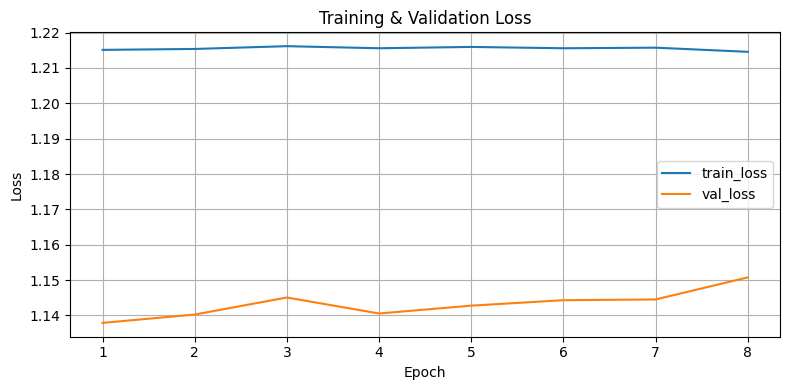

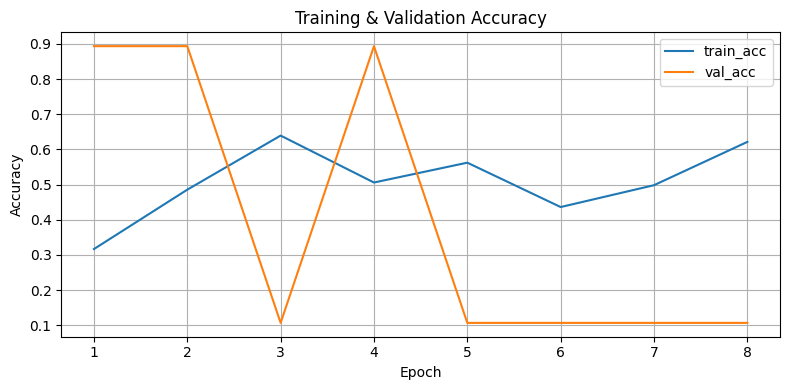

In [5]:
# 05_plot_curves
hist = joblib.load(PROJECT_ROOT / "models" / "lstm_history.joblib") if (PROJECT_ROOT / "models" / "lstm_history.joblib").exists() else history

epochs = range(1, len(hist['train_loss'])+1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist['train_loss'], label='train_loss')
plt.plot(epochs, hist['val_loss'], label='val_loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss"); plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "reports" / "visuals" / "lstm_loss_curve.png")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist['train_acc'], label='train_acc')
plt.plot(epochs, hist['val_acc'], label='val_acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training & Validation Accuracy"); plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "reports" / "visuals" / "lstm_accuracy_curve.png")
plt.show()


ROC AUC: 0.5239994262521944


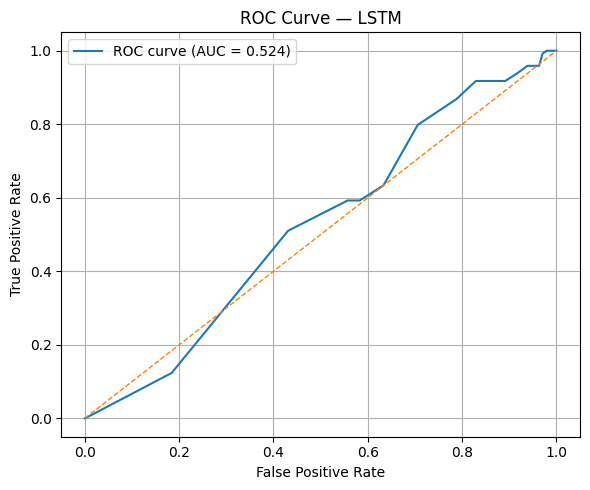


Classification Report (threshold=0.5):

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2037
           1     0.1066    1.0000    0.1926       243

    accuracy                         0.1066      2280
   macro avg     0.0533    0.5000    0.0963      2280
weighted avg     0.0114    0.1066    0.0205      2280

Accuracy: 0.10657894736842105


C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [6]:
# 06_roc
# collect all probs and true labels from test set
model.eval()
all_probs = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_targets.extend(yb.numpy().astype(int).tolist())

all_probs = np.array(all_probs)
all_targets = np.array(all_targets)

# compute ROC curve and AUC
fpr, tpr, thr = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], linestyle='--', linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — LSTM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "reports" / "visuals" / "lstm_roc_curve.png")
plt.show()

# Quick classification report at default 0.5
preds = (all_probs > 0.5).astype(int)
print("\nClassification Report (threshold=0.5):\n")
print(classification_report(all_targets, preds, digits=4))
print("Accuracy:", accuracy_score(all_targets, preds))


In [7]:
# diagnostics.py (run in notebook or .py)
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import joblib

PROJECT_ROOT = Path.cwd().parents[0] if "notebooks" in str(Path.cwd()) else Path.cwd()
# load stored probs & targets if you saved them; otherwise recompute from test_loader
# here assume variables `all_probs` and `all_targets` are available from prior ROC cell

print("Targets distribution:", np.bincount(all_targets))
print("Predicted probs stats:", np.min(all_probs), np.mean(all_probs), np.max(all_probs))

# classification at default 0.5
preds_05 = (all_probs > 0.5).astype(int)
print("Confusion matrix (0.5):")
print(confusion_matrix(all_targets, preds_05))
print(classification_report(all_targets, preds_05, digits=4))


Targets distribution: [2037  243]
Predicted probs stats: 0.5244359374046326 0.5244366441379513 0.5244369506835938
Confusion matrix (0.5):
[[   0 2037]
 [   0  243]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2037
           1     0.1066    1.0000    0.1926       243

    accuracy                         0.1066      2280
   macro avg     0.0533    0.5000    0.0963      2280
weighted avg     0.0114    0.1066    0.0205      2280



C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\LENOVO\Desktop\Projects\predictive_maintenance\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha